<a href="https://colab.research.google.com/github/neba378/amharic-handwritting-detection/blob/main/amharic_handwritting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:01<00:00, 93.9MB/s]


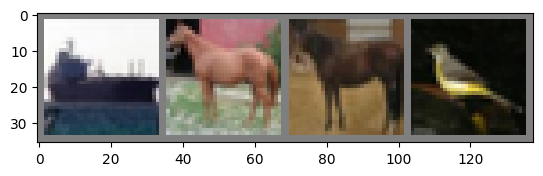

ship  horse horse bird 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.229
[1,  4000] loss: 1.894
[1,  6000] loss: 1.700
[1,  8000] loss: 1.603
[1, 10000] loss: 1.559
[1, 12000] loss: 1.493
[2,  2000] loss: 1.442
[2,  4000] loss: 1.396
[2,  6000] loss: 1.372
[2,  8000] loss: 1.342
[2, 10000] loss: 1.310
[2, 12000] loss: 1.310
Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

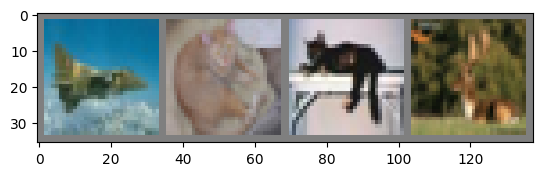

GroundTruth:  plane cat   cat   deer 


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# i want to get images that are randome not the same on the test


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

**This is the real challenge**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Colab_Notebooks/uni_dataset/uni_dataset"


STEP 1: INSTALL DEPENDENCIES

In [ ]:


!pip install albumentations opencv-python tqdm


STEP 2: IMPORTS

In [ ]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder


STEP 3: DATA AUGMENTATION & NORMALIZATION

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tf = A.Compose([
    A.Rotate(limit=10),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1),
    A.GaussNoise(var_limit=(5, 15)),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_tf = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1756399449.py:7: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 15)),


In [ ]:
import os, cv2

def clean_dataset(root):
    for cls in os.listdir(root):
        cls_path = os.path.join(root, cls)
        if not os.path.isdir(cls_path):
            continue

        for img in os.listdir(cls_path):
            path = os.path.join(cls_path, img)
            if cv2.imread(path, cv2.IMREAD_GRAYSCALE) is None:
                print("Removing:", path)
                os.remove(path)

clean_dataset(DATASET_PATH)


STEP 4: CUSTOM DATASET (GRAYSCALE OCR)

In [ ]:
# class AmharicDataset(ImageFolder):
#     def __init__(self, root, transform=None):
#         super().__init__(root)
#         self.transform = transform

#         # Filter out unreadable images
#         valid_samples = []
#         for path, label in self.samples:
#             try:
#                 # Attempt to read the image to check for validity
#                 image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#                 if image is not None:
#                     valid_samples.append((path, label))
#                 else:
#                     print(f"Warning: Skipping unreadable image at path: {path}")
#             except Exception as e:
#                 print(f"Error reading image {path}: {e}. Skipping.")
#         self.samples = valid_samples
#         # Update targets list to match the filtered samples
#         self.targets = [s[1] for s in valid_samples]

#     def __getitem__(self, index):
#         path, label = self.samples[index]
#         image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

#         if self.transform:
#             image = self.transform(image=image)["image"]

#         return image, label

class AmharicDataset(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root)
        self.transform = transform

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise RuntimeError(f"Failed to read image {path}")

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label


STEP 5: LOAD DATASET + 80 / 20 SPLIT

In [ ]:
full_dataset = AmharicDataset(DATASET_PATH, transform=train_tf)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
print(len(full_dataset), train_size, val_size)

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# Important: validation should NOT use augmentation
val_ds.dataset.transform = val_tf


37651 30120 7531


STEP 6: DATALOADERS

In [ ]:
BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

NUM_CLASSES = len(full_dataset.classes)
print("Classes:", NUM_CLASSES)


Classes: 237


TEP 7: OCR-STYLE CNN (OPTIMIZED)

In [ ]:
class AmharicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


STEP 8: TRAINING SETUP (OPTIMIZED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AmharicCNN(NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3
)


STEP 9: TRAINING LOOP

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


STEP 10: EVALUATION (TOP-1 & TOP-5 ACCURACY)

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct1, correct5, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            _, top5 = outputs.topk(5, dim=1)
            correct1 += (top5[:, 0] == y).sum().item()
            correct5 += sum(y[i] in top5[i] for i in range(len(y)))
            total += y.size(0)

    return correct1 / total, correct5 / total


STEP 11: FULL TRAINING (20–40 EPOCHS)

In [ ]:
os.makedirs("/content/drive/MyDrive/amharic_models", exist_ok=True)


In [ ]:
EPOCHS = 30
PATIENCE = 5

best_acc = 0.0
patience_counter = 0

SAVE_PATH = "/content/drive/MyDrive/amharic_models/best_amharic_model.pth"

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader)
    acc1, acc5 = evaluate(model, val_loader)

    scheduler.step(acc1)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Loss: {train_loss:.4f} | "
        f"Top1: {acc1:.4f} | Top5: {acc5:.4f}"
    )

    # ✅ Check improvement
    if acc1 > best_acc:
        best_acc = acc1
        patience_counter = 0

        torch.save(model.state_dict(), SAVE_PATH)
        print("✅ Model improved. Saved.")

    else:
        patience_counter += 1
        print(f"⏳ No improvement ({patience_counter}/{PATIENCE})")

    # ⛔ Early stopping
    if patience_counter >= PATIENCE:
        print("🛑 Early stopping triggered.")
        break


### new


In [3]:
# =============================================================================
# Amharic (Ge'ez) Handwritten Character Recognition — PyTorch
# =============================================================================

import os
import cv2
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from collections import Counter
from tqdm import tqdm

# ─── CONFIG ──────────────────────────────────────────────────────────────────
DATASET_PATH = "/content/drive/MyDrive/Colab_Notebooks/uni_dataset/uni_dataset"  # adjust
SAVE_DIR     = "/content/drive/MyDrive/amharic_models"
IMG_SIZE = 28
BATCH_SIZE   = 32
EPOCHS       = 40
PATIENCE     = 7
LR           = 3e-4
NUM_WORKERS  = 2
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Device: {DEVICE}")


Device: cuda


In [4]:
# ─── STEP 1: CLEAN DATASET (remove corrupt images) ──────────────────────────
def clean_dataset(root):
    removed = 0
    for cls in os.listdir(root):
        cls_path = os.path.join(root, cls)
        if not os.path.isdir(cls_path):
            continue
        for fname in os.listdir(cls_path):
            fpath = os.path.join(cls_path, fname)
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Removing corrupt: {fpath}")
                os.remove(fpath)
                removed += 1
    print(f"Cleaned {removed} corrupt images.")

clean_dataset(DATASET_PATH)


Cleaned 0 corrupt images.


In [5]:
# ─── STEP 2: CUSTOM DATASET ─────────────────────────────────────────────────
class AmharicDataset(Dataset):
    """
    Loads grayscale character images from an ImageFolder-style directory.
    Each subfolder = one class (Unicode char or class ID).
    """
    def __init__(self, root, img_size=64, augment=False):
        self.img_size = img_size
        self.augment = augment
        self.samples = []      # (path, label_index)
        self.classes = []      # class names sorted
        self.class_to_idx = {}

        # Discover classes (sorted for deterministic ordering)
        class_names = sorted([
            d for d in os.listdir(root)
            if os.path.isdir(os.path.join(root, d))
        ])
        self.classes = class_names
        self.class_to_idx = {c: i for i, c in enumerate(class_names)}

        # Collect all valid image paths
        for cls_name in class_names:
            cls_dir = os.path.join(root, cls_name)
            idx = self.class_to_idx[cls_name]
            for fname in os.listdir(cls_dir):
                fpath = os.path.join(cls_dir, fname)
                if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    self.samples.append((fpath, idx))

        self.targets = [s[1] for s in self.samples]
        print(f"Loaded {len(self.samples)} images across {len(self.classes)} classes.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        # Read as grayscale
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Cannot read image: {path}")

        # Resize to fixed size
        img = cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)

        # Optional augmentation (training only)
        if self.augment:
            img = self._augment(img)

        # Normalize to [0, 1], add channel dim → (1, H, W)
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).unsqueeze(0)  # (1, 64, 64)
        return img, label

    @staticmethod
    def _augment(img):
        """Simple augmentations using OpenCV — no extra deps needed."""
        h, w = img.shape
        # Random rotation ±10°
        angle = np.random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h), borderValue=255)

        # Random shift ±5%
        dx = int(np.random.uniform(-0.05, 0.05) * w)
        dy = int(np.random.uniform(-0.05, 0.05) * h)
        M_shift = np.float32([[1, 0, dx], [0, 1, dy]])
        img = cv2.warpAffine(img, M_shift, (w, h), borderValue=255)

        # Random noise
        if np.random.rand() > 0.5:
            noise = np.random.normal(0, 5, img.shape).astype(np.float32)
            img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

        return img


In [6]:
# ─── STEP 3: LOAD & SPLIT ────────────────────────────────────────────────────
full_dataset = AmharicDataset(DATASET_PATH, img_size=IMG_SIZE, augment=False)
NUM_CLASSES = len(full_dataset.classes)
print(f"Number of classes: {NUM_CLASSES}")

# Save class names for inference later
class_names_path = os.path.join(SAVE_DIR, "class_names.json")
with open(class_names_path, "w", encoding="utf-8") as f:
    json.dump(full_dataset.classes, f, ensure_ascii=False)
print(f"Class names saved to {class_names_path}")

# 80/20 split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create separate dataset objects so augmentation doesn't leak
class SubsetWrapper(Dataset):
    """Wraps a Subset and overrides augmentation behavior."""
    def __init__(self, subset, augment=False):
        self.subset = subset
        self.augment = augment
        self.dataset = subset.dataset

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index):
        real_idx = self.subset.indices[index]
        path, label = self.dataset.samples[real_idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Cannot read image: {path}")
        img = cv2.resize(img, (self.dataset.img_size, self.dataset.img_size),
                         interpolation=cv2.INTER_AREA)
        if self.augment:
            img = AmharicDataset._augment(img)
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).unsqueeze(0)
        return img, label

train_dataset = SubsetWrapper(train_ds, augment=True)
val_dataset   = SubsetWrapper(val_ds,   augment=False)


Loaded 37651 images across 237 classes.
Number of classes: 237
Class names saved to /content/drive/MyDrive/amharic_models/class_names.json


In [7]:
# ─── STEP 4: HANDLE CLASS IMBALANCE ──────────────────────────────────────────
train_labels = [full_dataset.targets[i] for i in train_ds.indices]
class_counts = Counter(train_labels)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)



In [8]:
# ─── STEP 5: CNN MODEL ───────────────────────────────────────────────────────
class AmharicCNN(nn.Module):
    """
    Architecture for 28×28 grayscale input:
      Conv Block 1: (1,28,28) → (32,14,14)
      Conv Block 2: (32,14,14) → (64,7,7)
      Conv Block 3: (64,7,7) → (128,3,3)
      Classifier: Flatten(128*3*3=1152) → 512 → Dropout → num_classes
    """
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1: (1, 28, 28) → (32, 14, 14)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2: (32, 14, 14) → (64, 7, 7)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3: (64, 7, 7) → (128, 3, 3)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = AmharicCNN(NUM_CLASSES).to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 805,037


In [9]:
# ─── STEP 6: LOSS, OPTIMIZER, SCHEDULER ──────────────────────────────────────
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3
)

In [10]:
# ─── STEP 7: TRAINING & EVALUATION FUNCTIONS ─────────────────────────────────
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for images, labels in tqdm(loader, desc="Evaluating", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return correct / total, np.array(all_preds), np.array(all_labels)


In [11]:
# ─── STEP 8: TRAINING LOOP WITH EARLY STOPPING ───────────────────────────────
import time

best_acc = 0.0
patience_counter = 0
best_model_path = os.path.join(SAVE_DIR, "best_amharic_model.pth")

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_acc, val_preds, val_labels = evaluate(model, val_loader)
    scheduler.step(val_acc)
    epoch_time = time.time() - epoch_start

    current_lr = optimizer.param_groups[0]['lr']
    print(
        f"Epoch {epoch:02d}/{EPOCHS} ({epoch_time:.1f}s) | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}"
    )

    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'num_classes': NUM_CLASSES,
        }, best_model_path)
        print(f"  -> Model saved (val_acc={val_acc:.4f})")
    else:
        patience_counter += 1
        print(f"  -> No improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print(f"\nBest validation accuracy: {best_acc:.4f}")


Epoch 01/40 (171.6s) | Train Loss: 3.8562 | Train Acc: 0.2351 | Val Acc: 0.6788 | LR: 0.000300
  -> Model saved (val_acc=0.6788)


Epoch 02/40 (164.5s) | Train Loss: 2.4007 | Train Acc: 0.5849 | Val Acc: 0.7797 | LR: 0.000300
  -> Model saved (val_acc=0.7797)


Epoch 03/40 (162.9s) | Train Loss: 2.0594 | Train Acc: 0.7078 | Val Acc: 0.8322 | LR: 0.000300
  -> Model saved (val_acc=0.8322)


Epoch 04/40 (163.0s) | Train Loss: 1.8884 | Train Acc: 0.7662 | Val Acc: 0.8562 | LR: 0.000300
  -> Model saved (val_acc=0.8562)


Epoch 05/40 (164.6s) | Train Loss: 1.7998 | Train Acc: 0.7944 | Val Acc: 0.8623 | LR: 0.000300
  -> Model saved (val_acc=0.8623)


Epoch 06/40 (166.8s) | Train Loss: 1.7338 | Train Acc: 0.8134 | Val Acc: 0.8750 | LR: 0.000300
  -> Model saved (val_acc=0.8750)


Epoch 07/40 (179.7s) | Train Loss: 1.6784 | Train Acc: 0.8317 | Val Acc: 0.8782 | LR: 0.000300
  -> Model saved (val_acc=0.8782)


Epoch 08/40 (170.5s) | Train Loss: 1.6352 | Train Acc: 0.8435 | Val Acc: 0.8813 | LR: 0.000300
  -> Model saved (val_acc=0.8813)


Epoch 09/40 (168.9s) | Train Loss: 1.5988 | Train Acc: 0.8537 | Val Acc: 0.8912 | LR: 0.000300
  -> Model saved (val_acc=0.8912)


Epoch 10/40 (166.2s) | Train Loss: 1.5689 | Train Acc: 0.8631 | Val Acc: 0.8820 | LR: 0.000300
  -> No improvement (1/7)


Epoch 11/40 (164.3s) | Train Loss: 1.5421 | Train Acc: 0.8700 | Val Acc: 0.8935 | LR: 0.000300
  -> Model saved (val_acc=0.8935)


Epoch 12/40 (164.6s) | Train Loss: 1.5252 | Train Acc: 0.8731 | Val Acc: 0.8926 | LR: 0.000300
  -> No improvement (1/7)


Epoch 13/40 (164.2s) | Train Loss: 1.4983 | Train Acc: 0.8838 | Val Acc: 0.8936 | LR: 0.000300
  -> Model saved (val_acc=0.8936)


Epoch 14/40 (162.7s) | Train Loss: 1.4831 | Train Acc: 0.8869 | Val Acc: 0.8975 | LR: 0.000300
  -> Model saved (val_acc=0.8975)


Epoch 15/40 (163.8s) | Train Loss: 1.4652 | Train Acc: 0.8925 | Val Acc: 0.9003 | LR: 0.000300
  -> Model saved (val_acc=0.9003)


Epoch 16/40 (166.6s) | Train Loss: 1.4480 | Train Acc: 0.8963 | Val Acc: 0.8968 | LR: 0.000300
  -> No improvement (1/7)


Epoch 17/40 (167.1s) | Train Loss: 1.4358 | Train Acc: 0.8993 | Val Acc: 0.8991 | LR: 0.000300
  -> No improvement (2/7)


Epoch 18/40 (168.3s) | Train Loss: 1.4198 | Train Acc: 0.9034 | Val Acc: 0.9037 | LR: 0.000300
  -> Model saved (val_acc=0.9037)


Epoch 19/40 (167.8s) | Train Loss: 1.4117 | Train Acc: 0.9062 | Val Acc: 0.9047 | LR: 0.000300
  -> Model saved (val_acc=0.9047)


Epoch 20/40 (168.1s) | Train Loss: 1.3939 | Train Acc: 0.9118 | Val Acc: 0.9032 | LR: 0.000300
  -> No improvement (1/7)


Epoch 21/40 (167.6s) | Train Loss: 1.3851 | Train Acc: 0.9134 | Val Acc: 0.9064 | LR: 0.000300
  -> Model saved (val_acc=0.9064)


Epoch 22/40 (169.3s) | Train Loss: 1.3827 | Train Acc: 0.9133 | Val Acc: 0.8978 | LR: 0.000300
  -> No improvement (1/7)


Epoch 23/40 (168.7s) | Train Loss: 1.3695 | Train Acc: 0.9172 | Val Acc: 0.9064 | LR: 0.000300
  -> No improvement (2/7)


Epoch 24/40 (169.3s) | Train Loss: 1.3610 | Train Acc: 0.9185 | Val Acc: 0.9090 | LR: 0.000300
  -> Model saved (val_acc=0.9090)


Epoch 25/40 (166.9s) | Train Loss: 1.3464 | Train Acc: 0.9237 | Val Acc: 0.9045 | LR: 0.000300
  -> No improvement (1/7)


Epoch 26/40 (166.0s) | Train Loss: 1.3395 | Train Acc: 0.9256 | Val Acc: 0.9064 | LR: 0.000300
  -> No improvement (2/7)


Epoch 27/40 (164.7s) | Train Loss: 1.3357 | Train Acc: 0.9261 | Val Acc: 0.9105 | LR: 0.000300
  -> Model saved (val_acc=0.9105)


Epoch 28/40 (168.3s) | Train Loss: 1.3229 | Train Acc: 0.9310 | Val Acc: 0.9141 | LR: 0.000300
  -> Model saved (val_acc=0.9141)


Epoch 29/40 (164.0s) | Train Loss: 1.3178 | Train Acc: 0.9312 | Val Acc: 0.9090 | LR: 0.000300
  -> No improvement (1/7)


Epoch 30/40 (169.7s) | Train Loss: 1.3164 | Train Acc: 0.9349 | Val Acc: 0.9112 | LR: 0.000300
  -> No improvement (2/7)


Epoch 31/40 (166.4s) | Train Loss: 1.3085 | Train Acc: 0.9367 | Val Acc: 0.9090 | LR: 0.000300
  -> No improvement (3/7)


Epoch 32/40 (168.8s) | Train Loss: 1.3046 | Train Acc: 0.9373 | Val Acc: 0.9088 | LR: 0.000150
  -> No improvement (4/7)


Epoch 33/40 (168.0s) | Train Loss: 1.2780 | Train Acc: 0.9433 | Val Acc: 0.9140 | LR: 0.000150
  -> No improvement (5/7)


Epoch 34/40 (168.7s) | Train Loss: 1.2678 | Train Acc: 0.9461 | Val Acc: 0.9148 | LR: 0.000150
  -> Model saved (val_acc=0.9148)


Epoch 35/40 (170.6s) | Train Loss: 1.2637 | Train Acc: 0.9495 | Val Acc: 0.9140 | LR: 0.000150
  -> No improvement (1/7)


Epoch 36/40 (169.2s) | Train Loss: 1.2595 | Train Acc: 0.9492 | Val Acc: 0.9122 | LR: 0.000150
  -> No improvement (2/7)


Epoch 37/40 (169.6s) | Train Loss: 1.2553 | Train Acc: 0.9507 | Val Acc: 0.9144 | LR: 0.000150
  -> No improvement (3/7)


Epoch 38/40 (167.6s) | Train Loss: 1.2528 | Train Acc: 0.9522 | Val Acc: 0.9112 | LR: 0.000075
  -> No improvement (4/7)


Epoch 39/40 (167.4s) | Train Loss: 1.2440 | Train Acc: 0.9547 | Val Acc: 0.9155 | LR: 0.000075
  -> Model saved (val_acc=0.9155)


Epoch 40/40 (164.7s) | Train Loss: 1.2406 | Train Acc: 0.9544 | Val Acc: 0.9163 | LR: 0.000075
  -> Model saved (val_acc=0.9163)

Best validation accuracy: 0.9163



Final Validation Accuracy: 0.9163

--- 10 Worst-performing classes (by F1) ---
  ኅ: F1=0.417 (support=9)
  ዶ: F1=0.478 (support=25)
  ፕ: F1=0.583 (support=25)
  ሽ: F1=0.615 (support=13)
  ጹ: F1=0.643 (support=26)
  ዱ: F1=0.678 (support=30)
  ደ: F1=0.679 (support=30)
  ጾ: F1=0.697 (support=32)
  ኘ: F1=0.700 (support=38)
  ጺ: F1=0.700 (support=32)


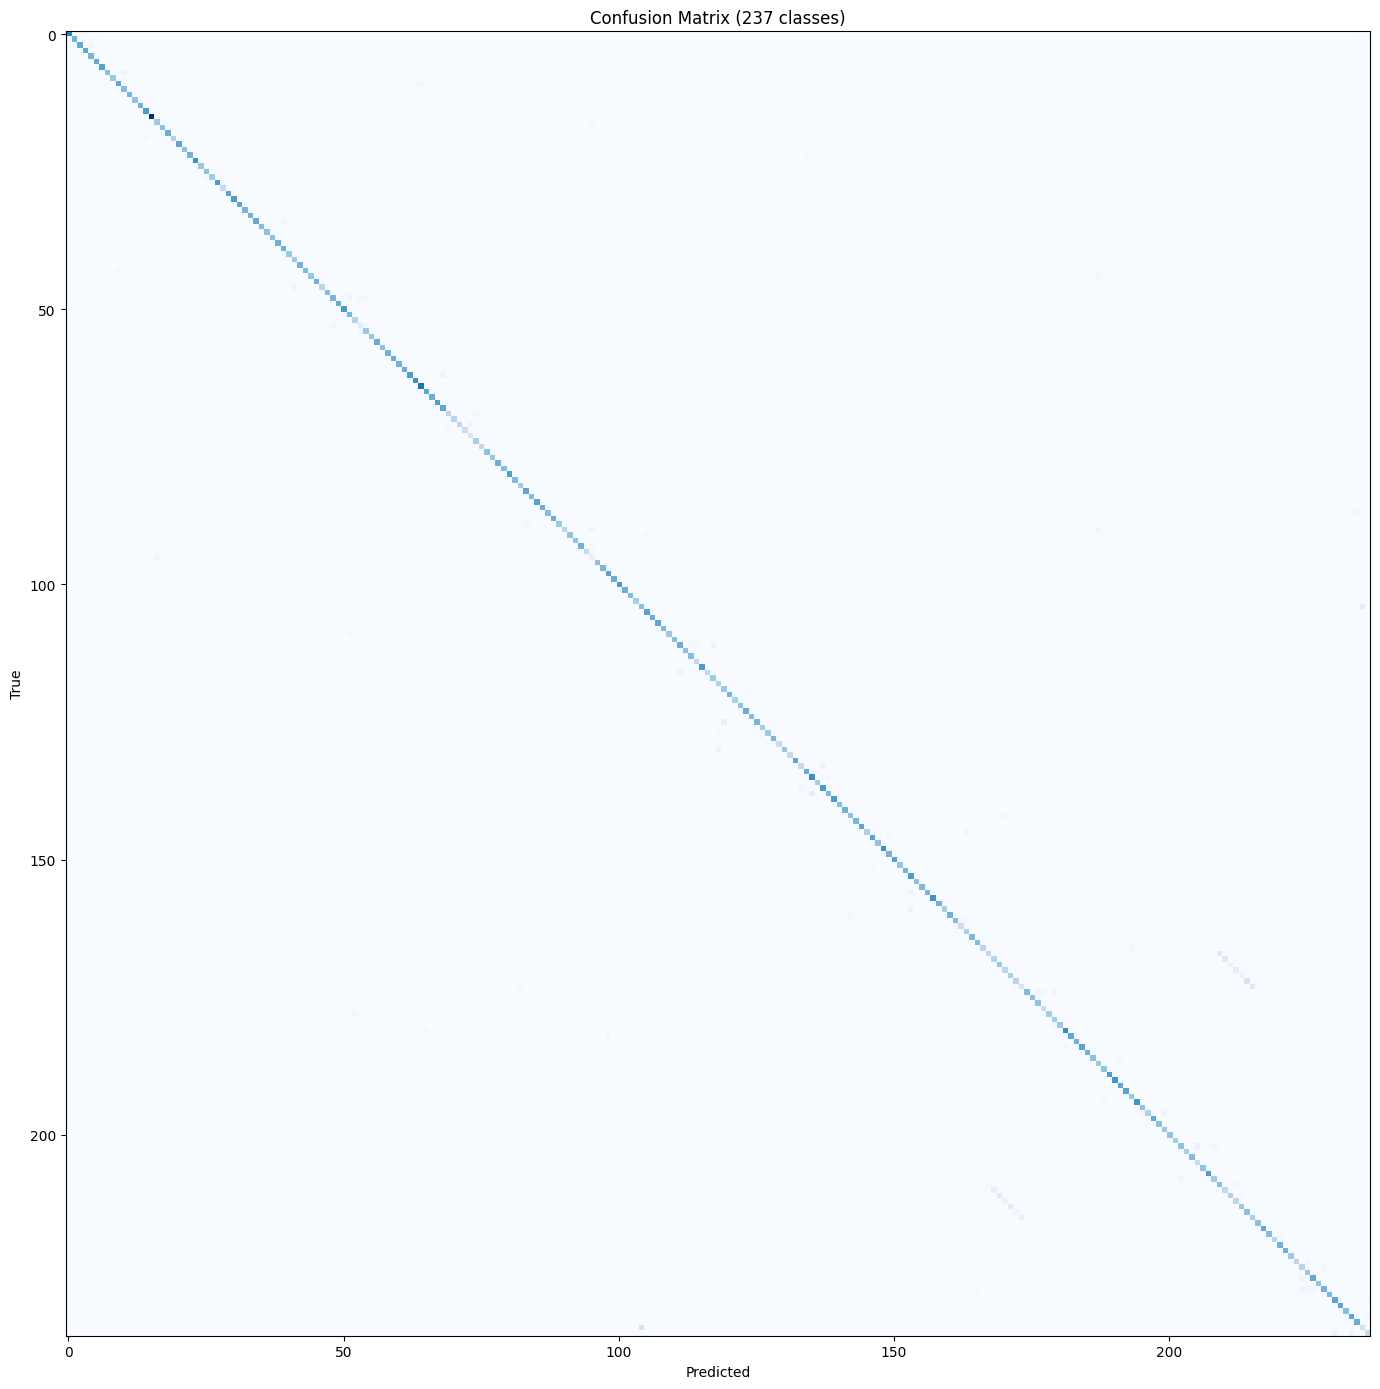

Confusion matrix saved.


In [12]:
# ─── STEP 9: CONFUSION MATRIX ────────────────────────────────────────────────
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load best model for evaluation
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
val_acc, val_preds, val_labels = evaluate(model, val_loader)

print(f"\nFinal Validation Accuracy: {val_acc:.4f}")

# Classification report (top/bottom classes)
report = classification_report(
    val_labels, val_preds,
    target_names=full_dataset.classes,
    output_dict=True, zero_division=0
)
# Print summary
per_class = [(cls, report[cls]['f1-score'], report[cls]['support'])
             for cls in full_dataset.classes if cls in report]
per_class.sort(key=lambda x: x[1])
print("\n--- 10 Worst-performing classes (by F1) ---")
for name, f1, sup in per_class[:10]:
    print(f"  {name}: F1={f1:.3f} (support={int(sup)})")

# Confusion matrix (downsampled visualization for readability)
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(cm, cmap='Blues', interpolation='nearest')
ax.set_title(f"Confusion Matrix ({NUM_CLASSES} classes)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"), dpi=150)
plt.show()
print("Confusion matrix saved.")


In [13]:
# ─── STEP 10: EXPORT FOR INFERENCE ───────────────────────────────────────────
# Save as TorchScript for production deployment
model.eval()
example_input = torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(DEVICE)
traced_model = torch.jit.trace(model, example_input)
scripted_path = os.path.join(SAVE_DIR, "amharic_model_scripted.pt")
traced_model.save(scripted_path)
print(f"TorchScript model saved to: {scripted_path}")



TorchScript model saved to: /content/drive/MyDrive/amharic_models/amharic_model_scripted.pt


In [14]:
# ─── STEP 11: INFERENCE FUNCTION ─────────────────────────────────────────────
def predict_character(image_path, model_path=None, class_names_path=None,
                      scripted_path=None, img_size=28, device="cpu"):
    """
    Predict the Amharic character from a single image.

    Args:
        image_path: Path to the input image (any size, any format).
        model_path: Path to the .pth checkpoint (use this OR scripted_path).
        class_names_path: Path to class_names.json.
        scripted_path: Path to TorchScript .pt file (preferred for production).
        img_size: Must match training (64).
        device: 'cpu' or 'cuda'.

    Returns:
        dict with 'character', 'class_index', 'confidence', 'top5'
    """
    import json

    device = torch.device(device)

    # Load class names
    if class_names_path is None:
        class_names_path = os.path.join(SAVE_DIR, "class_names.json")
    with open(class_names_path, "r", encoding="utf-8") as f:
        class_names = json.load(f)

    # Load model
    if scripted_path:
        model = torch.jit.load(scripted_path, map_location=device)
    else:
        if model_path is None:
            model_path = os.path.join(SAVE_DIR, "best_amharic_model.pth")
        checkpoint = torch.load(model_path, map_location=device)
        num_classes = checkpoint['num_classes']
        model = AmharicCNN(num_classes)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
    model.eval()

    # Preprocess
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {image_path}")
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,64,64)

    # Predict
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)
        top5_probs, top5_indices = probs.topk(5, dim=1)

    pred_idx = top5_indices[0, 0].item()
    pred_char = class_names[pred_idx]
    confidence = top5_probs[0, 0].item()

    top5 = [
        {"character": class_names[top5_indices[0, i].item()],
         "confidence": top5_probs[0, i].item()}
        for i in range(5)
    ]

    return {
        "character": pred_char,
        "class_index": pred_idx,
        "confidence": confidence,
        "top5": top5,
    }


In [21]:
pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.8 MB/s eta 0:00:00


In [23]:
import onnxruntime

# Option A: TorchScript (recommended — self-contained, no model class needed to reload)
model.eval()
example_input = torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(DEVICE)
traced_model = torch.jit.trace(model, example_input)
scripted_path = os.path.join(SAVE_DIR, "amharic_model_scripted.pt")
traced_model.save(scripted_path)
print(f"TorchScript model saved to: {scripted_path}")

# Option B: ONNX (cross-platform — works in JS, C++, mobile, etc.)
onnx_path = os.path.join(SAVE_DIR, "amharic_model.onnx")

# Move model to CPU temporarily for ONNX export
model_on_cpu = model.to("cpu")
example_input_cpu = torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to("cpu") # Ensure input is also on CPU

torch.onnx.export(
    model_on_cpu, # Use the model on CPU
    example_input_cpu, # Use the input on CPU
    onnx_path,
    input_names=["image"],
    output_names=["logits"],
    dynamic_axes={"image": {0: "batch"}, "logits": {0: "batch"}},
    opset_version=18, # Changed from 13 to 18
)
# Move model back to original device
model.to(DEVICE)
print(f"ONNX model saved to: {onnx_path}")

# ─── Verify exports ──────────────────────────────────────────────────────────
# TorchScript verification
loaded_ts = torch.jit.load(scripted_path, map_location="cpu")
test_input = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
with torch.no_grad():
    out = loaded_ts(test_input)
print(f"TorchScript output shape: {out.shape}")  # should be (1, 237)

# ONNX verification (optional, requires onnxruntime)
try:
    import onnxruntime as ort
    sess = ort.InferenceSession(onnx_path)
    onnx_out = sess.run(None, {"image": test_input.numpy()})
    print(f"ONNX output shape: {onnx_out[0].shape}")  # should be (1, 237)
    print("Both exports verified successfully.")
except ImportError:
    print("Install onnxruntime to verify ONNX: pip install onnxruntime")

TorchScript model saved to: /content/drive/MyDrive/amharic_models/amharic_model_scripted.pt


/tmp/ipython-input-1823000130.py:18: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `AmharicCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `AmharicCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 3 of general pattern rewrite rules.
ONNX model saved to: /content/drive/MyDrive/amharic_models/amharic_model.onnx
TorchScript output shape: torch.Size([1, 237])
ONNX output shape: (1, 237)
Both exports verified successfully.
